# Visualize Assistant Axis

This notebook loads a computed Assistant Axis and visualizes its cosine similarity with different trait persona vectors

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from huggingface_hub import hf_hub_download, snapshot_download
from huggingface_hub.utils import disable_progress_bars
from pathlib import Path

disable_progress_bars()

## Load Assistant Axis

In [2]:
# Precomputed models include: gemma-2-27b, qwen-3-32b, llama-3.3-70b
MODEL_NAME = "gemma-2-27b"
REPO_ID = "lu-christina/assistant-axis-vectors"
TARGET_LAYER = 22

# Load axis from HuggingFace
axis_path = hf_hub_download(repo_id=REPO_ID, filename=f"{MODEL_NAME}/assistant_axis.pt", repo_type="dataset")
axis = torch.load(axis_path, map_location="cpu", weights_only=False)

print(f"Axis shape: {axis.shape}")
print(f"Target layer: {TARGET_LAYER}")

Axis shape: torch.Size([46, 4608])
Target layer: 22


## Load persona vectors (traits) and compute cosine similarity with the Assistant Axis


In [3]:
# Download all vectors for this model at once
local_dir = snapshot_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    allow_patterns=f"{MODEL_NAME}/trait_vectors/*.pt"
)

# Load trait vectors
trait_vectors = {p.stem: torch.load(p, map_location="cpu", weights_only=False)
                 for p in Path(local_dir, MODEL_NAME, "trait_vectors").glob("*.pt")}

print(f"Loaded {len(trait_vectors)} trait vectors")

Loaded 240 trait vectors


In [4]:
# Compute cosine similarity at target layer
axis_layer = axis[TARGET_LAYER]
trait_sims = {name: F.cosine_similarity(vec[TARGET_LAYER], axis_layer, dim=0).item() for name, vec in trait_vectors.items()}

## Plot cosine similarity with persona vectors (traits) to characterize the Axis

In [5]:
def plot_similarity_line(cosine_sims, names, figsize=(8, 3), n_extremes=5, show_histogram=True):
    """Plot cosine similarities on a line."""
    projections = cosine_sims
    
    sorted_indices = np.argsort(projections)
    low_extreme_indices = list(sorted_indices[:n_extremes])
    high_extreme_indices = list(sorted_indices[-n_extremes:])
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    custom_cmap = LinearSegmentedColormap.from_list('RedBlue1', ['#e63946', '#457b9d'])
    
    proj_norm = (projections - projections.min()) / (projections.max() - projections.min())
    colors = custom_cmap(proj_norm)
    
    y_pos = np.zeros_like(projections)
    ax.scatter(projections, y_pos, c=colors, marker='D', s=40, alpha=0.6, edgecolors='none', zorder=3)
    
    if show_histogram:
        hist_counts, bin_edges = np.histogram(projections, bins=30, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        hist_scale = 0.4
        scaled_heights = hist_counts * hist_scale
        bin_norm = (bin_centers - projections.min()) / (projections.max() - projections.min())
        bin_colors = custom_cmap(bin_norm)
        ax.bar(bin_centers, scaled_heights, width=bin_width, alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)
    
    y_above = [0.15, 0.25, 0.35]
    y_below = [-0.15, -0.25, -0.35]
    
    for i, idx in enumerate(low_extreme_indices):
        label = names[idx].replace('_', ' ').title()
        x_pos = projections[idx]
        if i % 2 == 0:
            y_label = y_above[i // 2] if i // 2 < len(y_above) else y_above[-1]
            va = 'bottom'
            line_end = y_label - 0.02
        else:
            y_label = y_below[i // 2] if i // 2 < len(y_below) else y_below[-1]
            va = 'top'
            line_end = y_label + 0.02
        ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', alpha=0.4, linewidth=0.8, zorder=1)
        ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
    
    for i, idx in enumerate(reversed(high_extreme_indices)):
        label = names[idx].replace('_', ' ').title()
        x_pos = projections[idx]
        if i % 2 == 0:
            y_label = y_above[i // 2] if i // 2 < len(y_above) else y_above[-1]
            va = 'bottom'
            line_end = y_label - 0.02
        else:
            y_label = y_below[i // 2] if i // 2 < len(y_below) else y_below[-1]
            va = 'top'
            line_end = y_label + 0.02
        ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, line_end], '-', color='gray', alpha=0.4, linewidth=0.8, zorder=1)
        ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)
    
    max_abs = max(abs(projections.min()), abs(projections.max()))
    ax.annotate('Role-playing', xy=(-max_abs, -0.45), xytext=(-max_abs + max_abs * 0.25, -0.45),
                arrowprops=dict(arrowstyle='->', color='#e63946', lw=2),
                fontsize=12, fontweight='bold', color='#e63946', ha='left', va='center')
    ax.annotate('Assistant-like', xy=(max_abs, -0.45), xytext=(max_abs - max_abs * 0.25, -0.45),
                arrowprops=dict(arrowstyle='->', color='#457b9d', lw=2),
                fontsize=12, fontweight='bold', color='#457b9d', ha='right', va='center')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2, zorder=1)
    ax.tick_params(axis='x', length=12, width=1.5, pad=10)
    ax.tick_params(axis='y', length=0, width=0)
    ax.set_yticks([])
    ax.set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
    ax.set_ylim(-0.55, 0.5)
    ax.set_xlim(-1, 1)
    ax.grid(False)
    plt.tight_layout()
    return fig

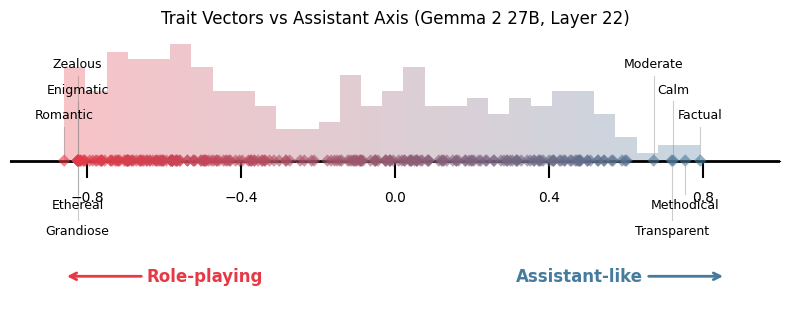

In [8]:
# Plot traits
trait_names = list(trait_sims.keys())
trait_cosine_sims = np.array([trait_sims[n] for n in trait_names])
fig = plot_similarity_line(trait_cosine_sims, trait_names, n_extremes=5)
plt.title(f"Trait Vectors vs Assistant Axis ({MODEL_NAME.replace('-', ' ').title()}, Layer {TARGET_LAYER})")
plt.show()